# (03c) Summary of extrinsic analysis

**Input files for this notebook:**

- `../data/osm_{study_area}_simple.graphml`
- `../data/ref_{study_area}_simple.graphml`
- `../results/extrinsic_analysis_{study_area}.json`
- `../results/grid_results_extrinsic_{study_area}.pickle`
- `../results/feature_matches_{study_area}.json`
- `../results/grid_results_feature_matching_{study_area}.pickle`

**Output files from this notebook:**

- `../results/summary_global_topology_metrics.png`
- `../results/summary_global_completeness_metrics.png`
- `../results/summary_plot_completeness_{study_area}.png`
- `../results/summary_plot_components_{study_area}.png`
- `../results/summary_plot_feature_matching_{study_area}.png`

**Overview:**

This notebook produces a quick overview of core results from the extrinsic analysis (notebooks 03a and 03b).

Only run this notebook once you have used a reference data set and successfully run the notebook for the [extrinsic analysis](03a_extrinsic_analysis_metrics.ipynb).

For further information on how to use and interpret the different metrics, we refer to the original analysis notebooks.

*For optimal results, we recommend to have Google Chrome installed on your device.*

**Sections:**

1. Load data and results
2. Summary: Global differences
3. Summary: Local differences
4. Summary: Feature matching
5. Export plots

### 1. Load data and results

In [42]:
import geopandas as gpd
import osmnx as ox
import yaml
import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as cx
import json
import pickle
import pandas as pd
from src import evaluation_functions as ef
from src import styling_functions as sf

#### Load settings

In [43]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_crs = parsed_yaml_file['study_crs']
    
print('Settings loaded!') 

Settings loaded!


#### Load data

In [44]:
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml')

with open(f'../data/osm_edges_simplified_{study_area}.pickle', 'rb') as fp:
    osm_edges_simplified = pickle.load(fp)

with open(f'../data/osm_nodes_simplified_{study_area}.pickle', 'rb') as fp:
    osm_nodes_simplified = pickle.load(fp)

ref_simplified_graph = ox.load_graphml(f'../data/ref_{study_area}_simple.graphml')

with open(f'../data/ref_nodes_simplified_{study_area}.pickle', 'rb') as fp:
    ref_nodes_simplified = pickle.load(fp)

with open(f'../data/ref_edges_simplified_{study_area}.pickle', 'rb') as fp:
    ref_edges_simplified = pickle.load(fp)

print('Data loaded!')

Data loaded!


#### Load results

In [45]:
with open(f'../results/extrinsic_analysis_{study_area}.json') as input_file:
    all_results = json.load(input_file)

with open(f'../results/grid_results_extrinsic_{study_area}.pickle', 'rb') as fp:
    grid = pickle.load(fp)

with open(f'../results/feature_matches_{study_area}.json') as input_file:
    fm_results = json.load(input_file)

with open(f'../results/grid_results_feature_matching_{study_area}.pickle', 'rb') as fp:
    grid_fm = pickle.load(fp)

#### Styling settings

In [6]:
cell_hover = {
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}

row_hover = {
    'selector': 'tr:hover',
    'props': [('background-color', '#eff7fa')]
}

caption = {
    'selector': 'caption',
    'props': 'caption-side: top; font-size:2em;'
}

cell_style =  {
    'selector': 'td', 
    'props': 'text-align: center; font-weight: bold;'
}

# Styling setting for completeness results
index_name_completeness = {
    'selector': '.index_name',
    'props': 'color:white; font-weight:bold; background-color: orange; font-size:1.3em;'
}

columns_completeness = {
    'selector': 'th',
    'props': 'background-color: orange; color: white; font-weight:bold; font-size:1.3em;'
}

def format_completeness_style(styler):
    styler.set_caption('Network Completeness Quality Metrics')
    styler.format(precision=2, na_rep=' - ', thousands=',', formatter={'pct_difference': lambda x: f'{str(x)} %', 'normalised_values_pct_difference' : lambda x: f'{str(x)} %'})
    styler.set_table_styles([cell_hover, row_hover, columns_completeness, caption, index_name_completeness, cell_style], overwrite=False)
    styler.applymap_index(lambda v: 'color:white; font-style: italic; font-weight:bold; background-color: orange; font-size:1em;', axis=0)
    styler.applymap(sf.style_pct_value_completeness, osm_bigger='color:blue;',osm_smaller='color:orange;')
    
    return styler

# Styling settings for topology results
index_name_topo = {
    'selector': '.index_name',
    'props': 'color:white; font-weight:bold; background-color: purple; font-size:1.3em;'
}

columns_topo = {
    'selector': 'th',
    'props': 'background-color: purple; color: white; font-weight:bold; font-size:1.3em;'
}

high_bad_topo = ['dangling_node_count','dangling_node_density_sqkm','component_count','component_gaps','count_overshoots','count_undershoots']
high_good_topo = ['largest_cc_pct_size','largest_cc_length_km']

topo_slice_inverse = high_bad_topo,['pct_difference','normalised_values_pct_difference']
topo_slice = high_good_topo,['pct_difference','normalised_values_pct_difference']

def format_topology_style(styler):
    styler.set_caption('Network Topology Quality Metrics')
    styler.format(precision=2, na_rep=' - ', thousands=',', formatter={'pct_difference': lambda x: f'{str(x)} %', 'normalised_values_pct_difference' : lambda x: f'{str(x)} %'})
    styler.set_table_styles([cell_hover, row_hover, columns_topo, caption, index_name_topo, cell_style], overwrite=False)
    styler.applymap_index(lambda v: 'color:white; font-style: italic; font-weight:bold; background-color: purple; font-size:1em;', axis=0)
    styler.applymap(sf.style_pct_value, osm_better='color:blue;',osm_worse='color:green;',subset=topo_slice)
    styler.applymap(sf.style_pct_value_inversed, osm_better='color:blue;',osm_worse='color:green;',subset=topo_slice_inverse)
    
    return styler

____________________________

### 2. Global differences

Below, the global differences (i.e. metrics covering the whole study area) betweeen the two datasets are summarized.

The metrics are in this section categorised as either describing **network completeness** (for example network density) or **network topology** (for example connected component count).

In [7]:
osm_df = pd.DataFrame.from_dict(all_results['osm_results'], orient='index')
ref_df = pd.DataFrame.from_dict(all_results['ref_results'], orient='index')

osm_df.rename(columns={0:'OSM'},inplace=True)
ref_df.rename(columns={0:'reference'}, inplace=True)

combined_results = pd.concat([osm_df, ref_df], axis=1)

combined_results = combined_results.round(2)

combined_results['pct_difference'] = combined_results.apply( lambda x: ef.find_pct_diff(x, 'OSM', 'reference'), axis=1)

select_completeness_results = ['edge_density_m_sqkm', 'node_density_sqkm',
       'protected_density_m_sqkm','unprotected_density_m_sqkm', 'mixed_density_m_sqkm']
       
completeness_results = combined_results.loc[select_completeness_results]

completeness_results.index.name = 'Quality Metrics'

select_topology_results = ['dangling_node_count','dangling_node_density_sqkm', 
       'simplified_edge_pct_diff', 'simplified_node_pct_diff', 'alpha', 'beta', 'gamma', 'component_count',
       'largest_cc_pct_size', 'largest_cc_length_km', 'component_gaps',
       'count_overshoots', 'count_undershoots']
       
topology_results = combined_results.loc[select_topology_results]

topology_results['OSM_normalised'] = topology_results.OSM / (osm_edges_simplified.length.sum()/1000)

topology_results['reference_normalised'] = topology_results.reference / (ref_edges_simplified.length.sum()/1000)

topology_results['normalised_values_pct_difference'] = topology_results.apply( lambda x: ef.find_pct_diff(x, 'OSM_normalised','reference_normalised'), axis=1)

# Some values cannot meaningfully be normalised per network length
topology_results.loc[['largest_cc_pct_size','alpha', 'beta','gamma'],['OSM_normalised','reference_normalised']] = None

topology_results.index.name = 'Quality Metrics'

#### Network completeness

In the table below, values are colored based on whether the results indicate a more complete dataset in the OSM data (<span style='color:blue'>blue</span>) or in the reference data (<span style='color:orange'>orange</span>). 

Whether differences in the coverage or completeness of the data are due to errors of omission or commission requires further analysis - and ideally familiarity with the study area. 

In the interpretation we assume differences in network density etc. to be due to errors of comisssion - but if you know that this assumption is false for your study area, the interpretation of differences in largest component etc. should of course be adjusted.

In [8]:
completeness_results.style.pipe(format_completeness_style)

,OSM,reference,pct_difference
Quality Metrics,,,
edge_density_m_sqkm,"5,871.84","3,453.85",51.86 %
node_density_sqkm,26.13,20.57,23.81 %
protected_density_m_sqkm,"5,309.66","2,998.80",55.63 %
unprotected_density_m_sqkm,507.46,455.05,10.89 %
mixed_density_m_sqkm,54.55,0.00,200.0 %


#### Network topology

When comparing the values for respectively the OSM and the reference data, the value for the OSM data is taken as the basis, to which the value for the reference data is compared. In the columns computing the percentual difference, positive values thus means that the original metric value is highest for the OSM data, while negative value for pct difference means that the metric value is highest for the reference data.

In the table below, values are colored based on whether the results indicate a higher quality for the OSM data (<span style='color:blue'>blue</span>) or the reference data (<span style='color:green'>green</span>). For some metrics, a high value indicates high quality - e.g. how many percent of the network is included in the largest component or the edge/component ratio, while it for other metrics indicates lower quality (e.g. the number of overshoots).

To account for differences in the extent of the network, the column contains two columns comparing the OSM and the reference data: One comparing the original values ('pct_diff') and one comparing the metric value per kilometer of edges. In this way, we account for e.g. situations where a higher number of potential topological differences in a dataset might be explained by that dataset covering much more infrastructure.

For some metrics - such as the number of edges per kilometer or the difference in node count between the simplified and non-simplified graphs - we cannot judge whether high or low values are an indication of data quality, without further inspection.

In the interpretation of some metrics - e.g. the length of the largest component - we assume that the dataset with more kilometers mapped is the correct one (i.e. we assume that in case of differences, it is a case of ommission by the smaller dataset, not a case of commission by the larger one). If you know that this assumption is false for your study area, the interpretation of differences in largest component etc. should of course be adjusted.

In [9]:
topology_results.style.pipe(format_topology_style)

,OSM,reference,pct_difference,OSM_normalised,reference_normalised,normalised_values_pct_difference
Quality Metrics,,,,,,
dangling_node_count,"1,788.00",872.00,68.87 %,2.21,1.39,45.52 %
dangling_node_density_sqkm,9.86,4.81,68.85 %,0.01,0.01,45.5 %
simplified_edge_pct_diff,89.03,59.46,39.83 %,0.11,0.09,14.87 %
simplified_node_pct_diff,84.65,62.75,29.72 %,0.10,0.10,4.46 %
alpha,0.12,0.10,18.18 %,-,-,-7.24 %
beta,1.16,1.15,0.87 %,-,-,-24.48 %
gamma,0.39,0.38,2.6 %,-,-,-22.78 %
component_count,346.00,206.00,50.72 %,0.43,0.33,26.23 %
largest_cc_pct_size,92.57,80.02,14.54 %,-,-,-10.89 %


____________________________

### 3. Local differences

Differences in global values for the quality metrics will be the most important aspect when assessing fitness for use for most use cases. An important feature of VGI data and data quality is however that data quality and the presence of errors and inaccuraries are not randomly distributed, but often show some type of spatial autocorrelation. Therefore, it is also of interest to identify any local patterns in data completeness and quality.

To aid in the interpretation of local variation in data quality, we map the local calculations of data quality in 3 differens 'small multiples' plots covering respectively *completeness*, *data structure & topology*, and the results from the analysis of *network components*.

#### Completeness

For completeness, we plot the values for:
- edge and node densities for both datasets and the difference between them
- the density of respectively protected, unprotected and mixed* cycling infrastructure in both datasets, and the differences between them

To aid the interpretation of the plots, the cell values for plots for the same metric in the OSM and reference data are visualised using the same value range.

The interpretation of the plots is fairly straightforward, and as always, the difference between the datasets are computed as `osm value`- `reference value`. In the difference plots, positive values thus indicate a higher density for the OSM data, whule negative values indicate a higher density for the reference data.

It is important to note that node density, when looked at in isolation, does not equate more infrastructure mapped. For example will a dataset where some edges have small unintentional gaps have a higher node density than another where the same lenght of edges are correctly connected.

**A bidirectional edge indicating a street with protected infrastructure on one side and unprotected infrastructure on the other.*

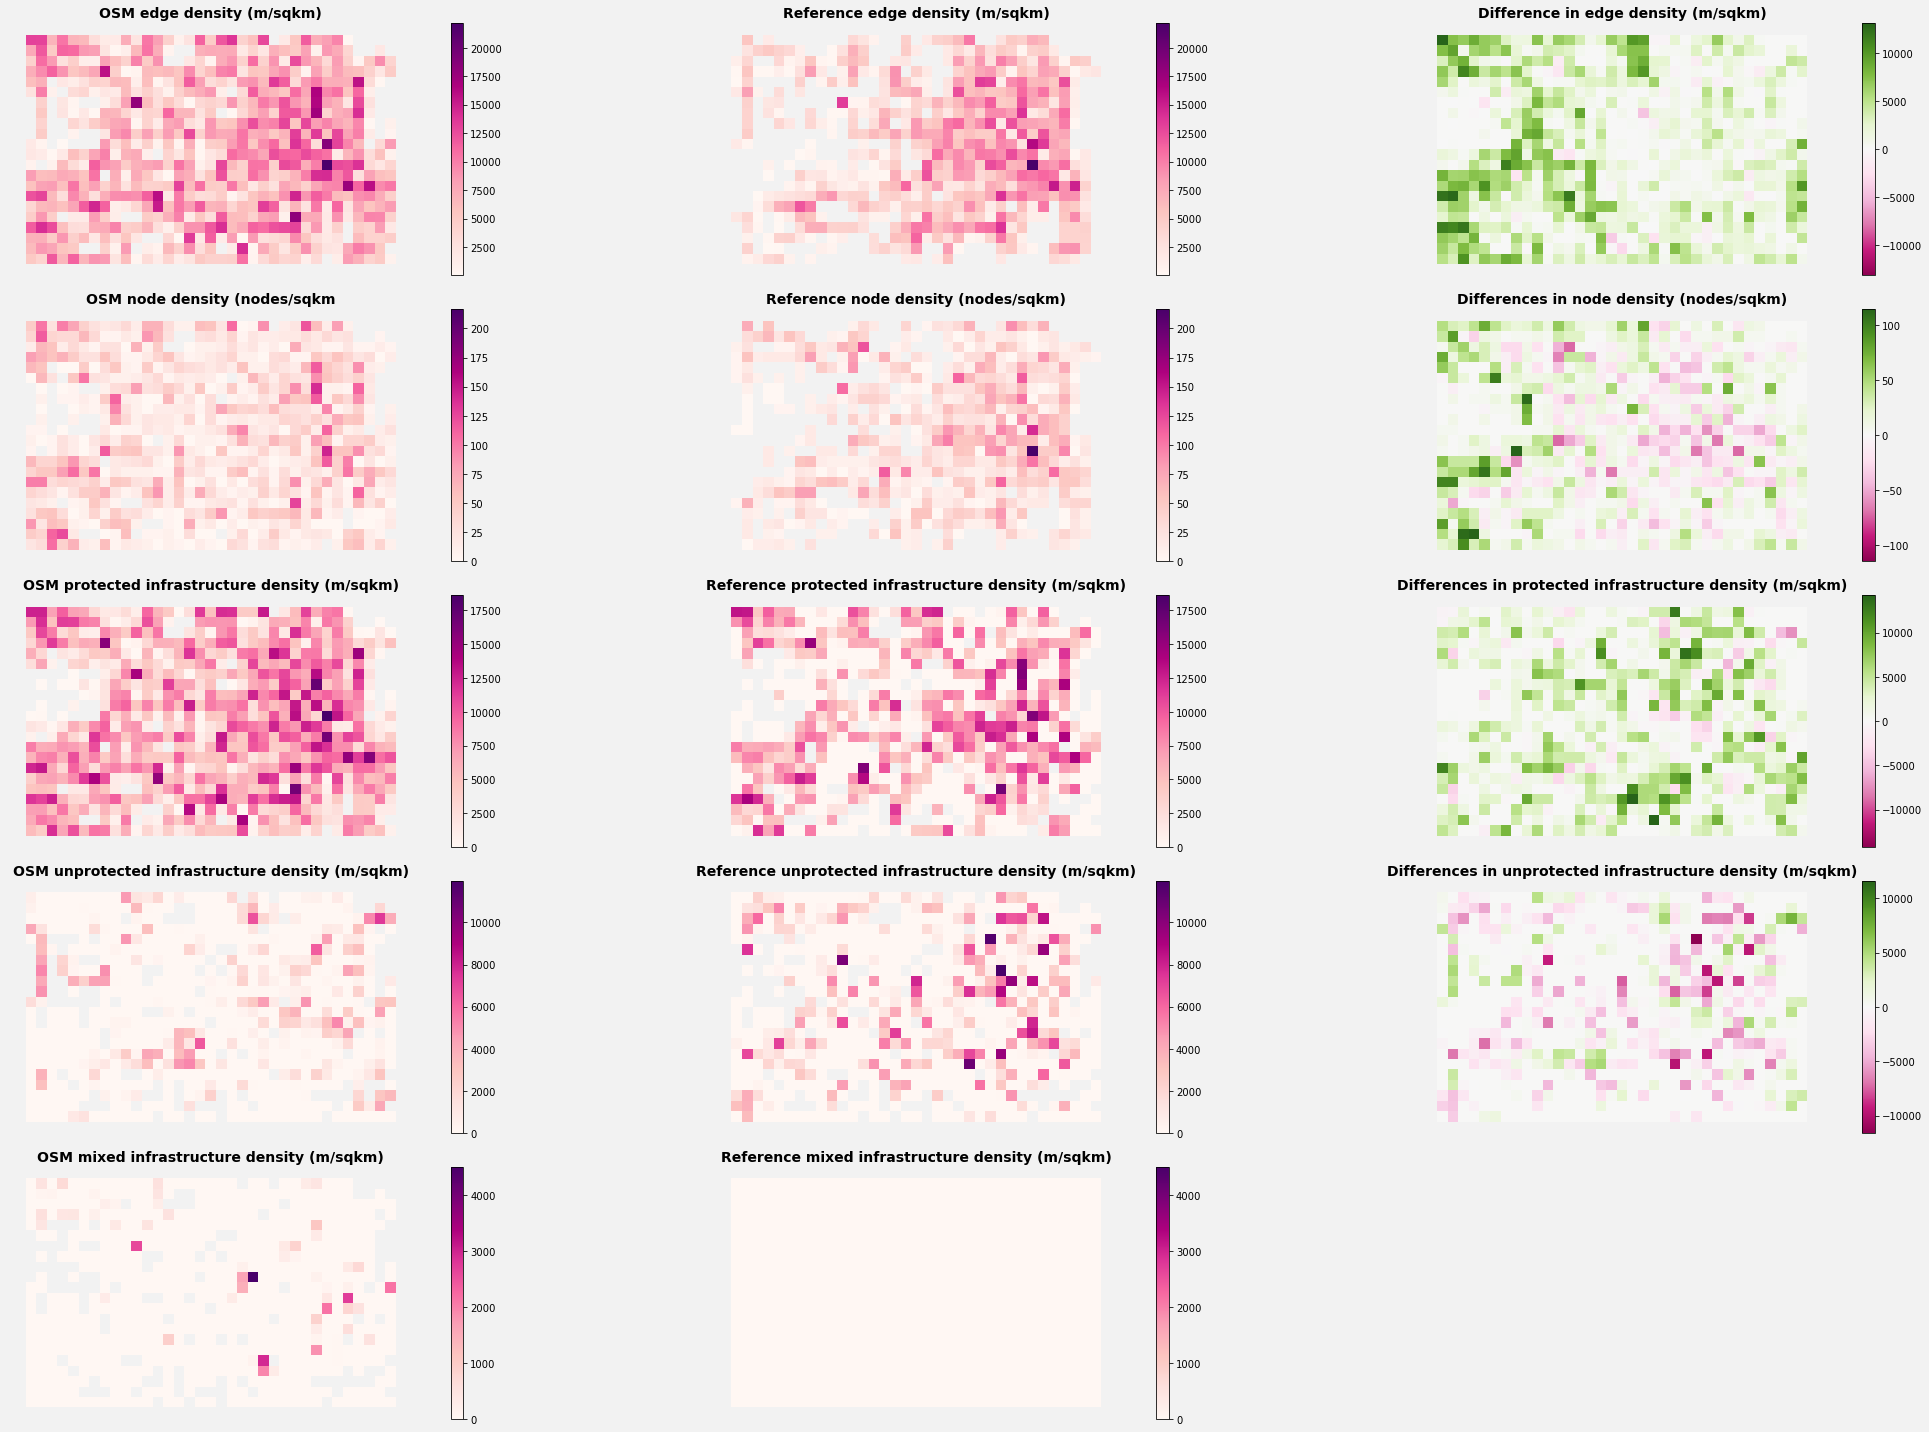

In [41]:
fig_completeness, axes = plt.subplots(nrows=5,ncols=3, figsize=(30,20))

axes = axes.flatten()

fig_completeness.set_facecolor('#f2f2f2')

plot_cols = [
    'osm_edge_density','ref_edge_density','edge_density_diff',
    'osm_node_density','ref_node_density','node_density_diff',
    'osm_protected_density','ref_protected_density', 'protected_density_diff',
    'osm_unprotected_density','ref_unprotected_density','unprotected_density_diff',
    'osm_mixed_density','ref_mixed_density','mixed_density_diff'
    ]

titles = [
    'OSM edge density (m/sqkm)', 'Reference edge density (m/sqkm)', 'Difference in edge density (m/sqkm)',
    'OSM node density (nodes/sqkm', 'Reference node density (nodes/sqkm)', 'Differences in node density (nodes/sqkm)',
    'OSM protected infrastructure density (m/sqkm)', 'Reference protected infrastructure density (m/sqkm)', 'Differences in protected infrastructure density (m/sqkm)',
    'OSM unprotected infrastructure density (m/sqkm)','Reference unprotected infrastructure density (m/sqkm)', 'Differences in unprotected infrastructure density (m/sqkm)',
    'OSM mixed infrastructure density (m/sqkm)', 'Reference mixed infrastructure density (m/sqkm)', 'Differences in mixed infrastructure density (m/sqkm)'
    ]

if grid.ref_mixed_density.sum() == 0 or grid.osm_mixed_density.sum() == 0: # Do not plot difference if not both dataset have mixed infrastructure edges
    plot_cols = plot_cols[:-1]
    titles = titles[:-1]
    axes.flat[-1].set_visible(False) 

cmap_diff = 'PiYG' #'RdBu'
cmap_abs = 'RdPu'

for i, c in enumerate(plot_cols):
    ax = axes[i]
    ax.set_axis_off()

    if i in [2, 5, 8, 11, 14] and grid[c].min() < 0:

        # Created a normalize colorbar centered on 0
        cblim = max(abs(min(grid[c])), max(grid[c]))
        cbnorm = mpl.colors.Normalize(vmin=-cblim, vmax=cblim)
        grid.plot(column=c, cmap=cmap_diff, norm=cbnorm, legend=True, ax=ax)
  
    elif i in [2, 5, 8, 11, 14] and grid[c].min() >= 0:
        grid.plot(column= c, ax=ax, cmap = cmap_diff, legend=True)

    else:
        # Create uniform legend range OSM and reference plots
        if i in [0,3,6,9,12]:
            max_value = max(grid[c].max(),grid[plot_cols[i+1]].max())
            min_value = min(grid[c].min(),grid[plot_cols[i+1]].min())

        else:
            max_value = max(grid[c].max(),grid[plot_cols[i-1]].max())
            min_value = min(grid[c].min(),grid[plot_cols[i-1]].min())

        grid.plot(column=c, ax=ax, legend=True,vmin=min_value, vmax=max_value, cmap=cmap_abs)
            
    ax.set_title(titles[i],  {'fontsize': 14,'fontweight': 'bold'})

plt.tight_layout()

#### Structure & Topology

For an overview of local network structure and topology - and the differences between them in the two datasets - we plot the local values for edge/node ratio and dangling node/node ratio.
Other metrics indicating the topological data quality, such as over and undershoots, are (hopefully) only rare, and are thus less meaningful to visualise for the whole study area. To inspect those we refer to the more detailed plots in the notebook with the [extrinsic analysis metrics](03a_extrinsic_analysis_metrics.ipynb).

When looking at edge/node ratios, low values indicates that there are as many (or almost as many) edges and nodes in a cell. A low edge/node ratio is thus an indication of many dead-ends.
If a low edge/node ratio is not the result of a low network density, it can be an indication of unintentional gaps between edges and components.

Positive values for the difference in edge-node ratio indicates that there in the given cell are more edges per node in OSM data than in the reference data - negative values represent the opposite scenario.
The values are not normalised with respect to differences in data completeness or network density - but large differences do nevertheless still indicate differences in network structure that will be significant when using data for network-based analysis.

For the dangling node/node ratio, a value of ~1, all nodes in the cells are dangling nodes. This means that we either have dead-ends or that edges have not been properly connected.
Values close to 0 on the other hand indicate few or no dead-ends.
Again, positive values for the difference computation represents a higher ratio for OSM than the reference data, and negative values indicate a higher ratio (and thus more dangling nodes per node) for the reference data.


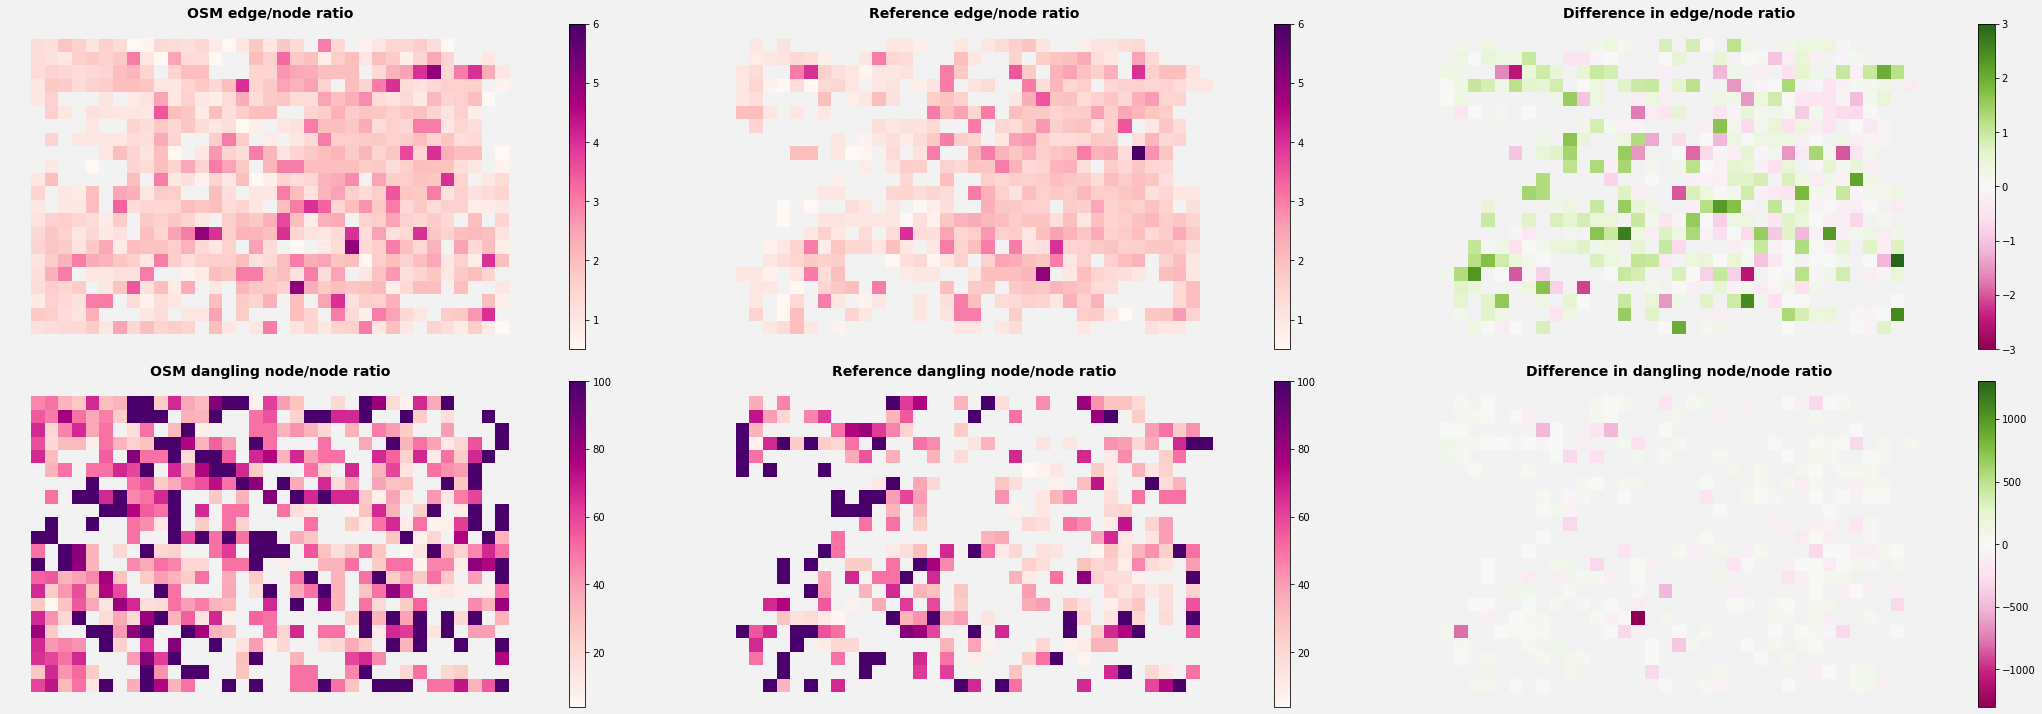

In [32]:
# TODO change to average node degree

fig_structure, axes = plt.subplots(nrows=2,ncols=3, figsize=(30,10))
axes = axes.flatten()
fig_structure.set_facecolor('#f2f2f2')

plot_cols = [
    'osm_edge_node_ratio', 'ref_edge_node_ratio','edge_node_ratio_diff',
    'osm_dangling_nodes_pct','ref_dangling_nodes_pct','dangling_nodes_diff_pct'   
    ]

titles = ['OSM edge/node ratio', 'Reference edge/node ratio','Difference in edge/node ratio',
    'OSM dangling node/node ratio','Reference dangling node/node ratio', '% difference in dangling node/node ratio'
    ]

cmap = 'RdPu'
cmap_diff = 'PiYG'

for i, c in enumerate(plot_cols):
    ax = axes[i]
    ax.set_axis_off()

    if i in [2,5]:
        # Create a normalized colorbar centered on 0
        cblim = max(abs(min(grid[c].fillna(value=0))), max(grid[c].fillna(value=0)))
        cbnorm = mpl.colors.Normalize(vmin=-cblim, vmax=cblim)
    
        grid.plot(column=c, cmap=cmap_diff, norm=cbnorm, legend=True, ax=ax)
    
    else:
        if i in [0,3]:
            max_value = max(grid[c].max(),grid[plot_cols[i+1]].max())
            min_value = min(grid[c].min(),grid[plot_cols[i+1]].min())

        elif i in [1,4]:
            max_value = max(grid[c].max(),grid[plot_cols[i-1]].max())
            min_value = min(grid[c].min(),grid[plot_cols[i-1]].min())
       
        grid.plot(column=c, ax=ax, legend=True,vmin=min_value, vmax=max_value, cmap=cmap)

    ax.set_title(titles[i],  {'fontsize': 14,'fontweight': 'bold'})

plt.tight_layout()

#### Components

To understand the extent to which connectivity in the two datasets differs, and how it might influence analyses looking at e.g. accessibility, we plot:

- unconnected components in both datasets
- unconnected but adjacent components
- difference in cell reach between the OSM and reference data

The 'unconnected but adjacent components' are components which topologically are unconnected, but only have a small gap between them. Oftentimes, cycling networks are fragmented into many unconnected components. 
When two components only are separated by a small gap, for example of 10 meters or less, it can however be due to digitizing errors or the omission of crossings and other types of infrastructure, that serves as connectors.
If this is the case, the failure to properly connect different parts of the network can result in misleading and vastly underestimated values of connectivity and accessibility.

The last plot summarizes this point by showing the differences in how many cells you can reach from a given cell, based on the components intersecting that cell.
It is a crude measure for connectivity (a cells reach is based on all the components intersectinh that cell, even though they might not be internally connected), but provides a quick overview of significant differences in network connectivity. It is moreover specifically designed to highlight places where e.g. an accessibility analysis would differ greatly depending on which dataset is used.

As always, values above zero indicate more cells reached using OSM, while negative values indicate more cells reached using the reference data.

In [26]:
# Create component data for plotting
osm_components = ef.return_components(osm_simplified_graph)
ref_components = ef.return_components(ref_simplified_graph)

osm_component_edges = ef.get_component_edges(osm_components, study_crs)
ref_component_edges = ef.get_component_edges(ref_components, study_crs)

osm_comp_issues = ef.find_adjacent_components(components=osm_components, buffer_dist=10, crs=study_crs, edge_id='edge_id')
ref_comp_issues = ef.find_adjacent_components(components=ref_components, buffer_dist=10, crs=study_crs, edge_id='edge_id')

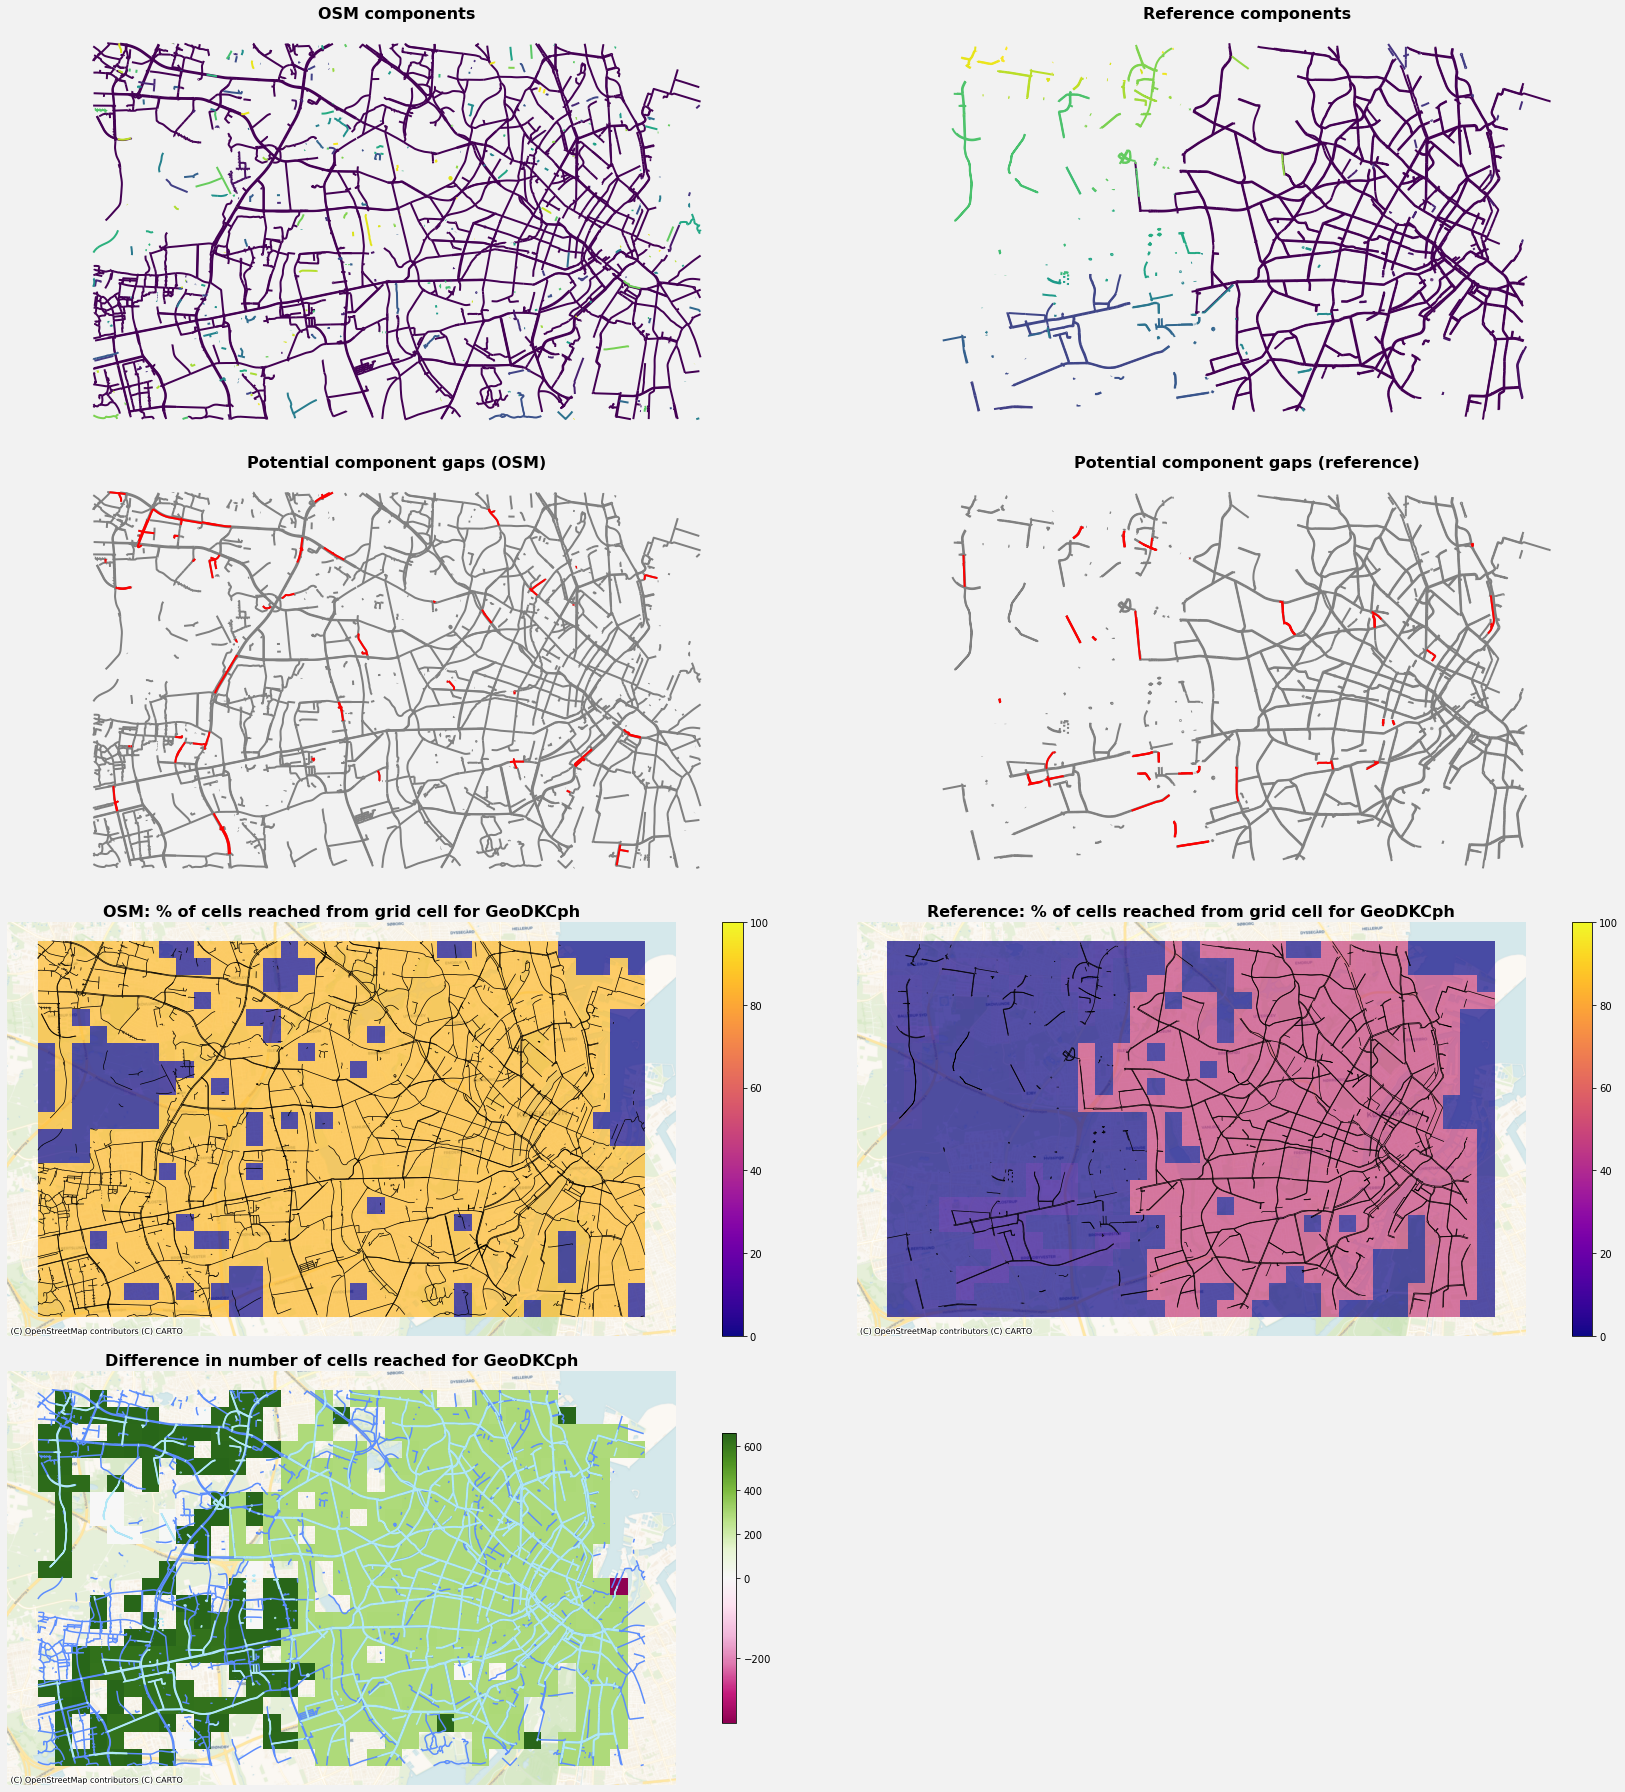

In [33]:
fig_components, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))

axes = axes.flatten()
axes.flat[-1].set_visible(False) 
fig_components.set_facecolor('#f2f2f2')
cmap_diff = 'PiYG'

titles = [
    'OSM components',
    'Reference components',
    'Potential component gaps (OSM)',
    'Potential component gaps (reference)',
    f'OSM: % of cells reached from grid cell for {study_area}',
    f'Reference: % of cells reached from grid cell for {study_area}',
    f'Difference in number of cells reached for {study_area}',
    '']


con_labels = ['cells_reached_osm_pct', 'cells_reached_ref']
con_clim= max(grid[con_labels].max())
con_cbnorm = mpl.colors.Normalize(vmin=0, vmax=100)

for i in range(len(axes)):
    ax = axes[i]
    ax.set_axis_off()

    linewidth = 2
    if i == 0:
       osm_component_edges.plot('component_id',ax=ax, linewidth=linewidth)
       
    elif i == 1:
        ref_component_edges.plot('component_id',ax=ax, linewidth=linewidth)

    elif i == 2:
        osm_edges_simplified.plot(ax=ax, color='grey',linewidth=linewidth)
        osm_comp_issues.plot(ax=ax, color='red', linewidth=linewidth)

    elif i == 3:
        ref_edges_simplified.plot(ax=ax, color='grey',linewidth=linewidth)
        ref_comp_issues.plot(ax=ax, color='red', linewidth=linewidth)

    elif i == 4:
        grid.plot(
            ax = ax, 
            column = "cells_reached_osm_pct",
            legend=True, 
            cmap = "plasma",
            norm = con_cbnorm,
            alpha = 0.7)
        osm_edges_simplified.plot(ax=ax, color='black', linewidth = 0.7)
        cx.add_basemap(ax = ax, crs=study_crs, source=cx.providers.CartoDB.Voyager)
        ax.set_title('OSM: % of cells reached from grid cell for ' + study_area)
        ax.set_axis_off()

    elif i == 5:
        grid.plot(
            ax = ax, 
            column = "cells_reached_ref_pct",
            legend=True, 
            cmap = "plasma",
            norm = con_cbnorm,
            alpha = 0.7)
        ref_edges_simplified.plot(ax=ax, color='black', linewidth = 0.7)
        cx.add_basemap(ax = ax, crs=study_crs, source=cx.providers.CartoDB.Voyager)
        ax.set_title('Reference: % of cells reached from grid cell for ' + study_area)
        ax.set_axis_off()

    elif i == 6:
        # TODO: NORM
        vmin, vmax, vcenter = grid['cell_reach_diff'].min(), grid['cell_reach_diff'].max(), 0
        norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap_diff)
    
        grid.loc[(grid.cells_reached_osm!= 0) & (grid.cells_reached_ref!=0)].plot(ax=ax, column='cell_reach_diff', norm=norm, cmap=cmap_diff, legend=True, legend_kwds={'shrink': 0.7})
        
        osm_edges_simplified.plot(ax=ax, color='#5C8DFE')
        ref_edges_simplified.plot(ax=ax, color='#B1E9F6')
        cx.add_basemap(ax = ax, crs=study_crs, source=cx.providers.CartoDB.Voyager)
    
    ax.set_title(titles[i],  {'fontsize': 16,'fontweight': 'bold'})
    plt.tight_layout() 

#### 4. Feature Matching

Below is a summary of the result of the feature matching between the two datasets. As mentioned above, the analysis itself cannot determine whether differences are due to errors of omission or comission.

As described in the [feature matching notebook](./03b_extrinsic_analysis_feature_matching.ipynb), unmatched edges can both be due to differences in data coverage - i.e. the OSM dataset might contain features not mapped in the reference dataset or vice versa, or the feature matching might fail due to too spatial inaccuracies or large discrepancies in how features have been maped (for example if the distance between the same path in the two datasets is more than the threshold used for the feature matching).

Even small missing or surplus features in a dataset can be significant for some types of analysis, since e.g. the omission of small connector paths can change accessiblity/connectivity drastically. For other purposes, the summed length of infrastructure is of more importance. The plots below thus both present the count and length* of matched/unmatched features in each dataset.


**In this context, the length refer to the geometric length of the edge, not the infrastructure length. We do thus not take into account whether an unmatched edge for example is bidirectional or not.*

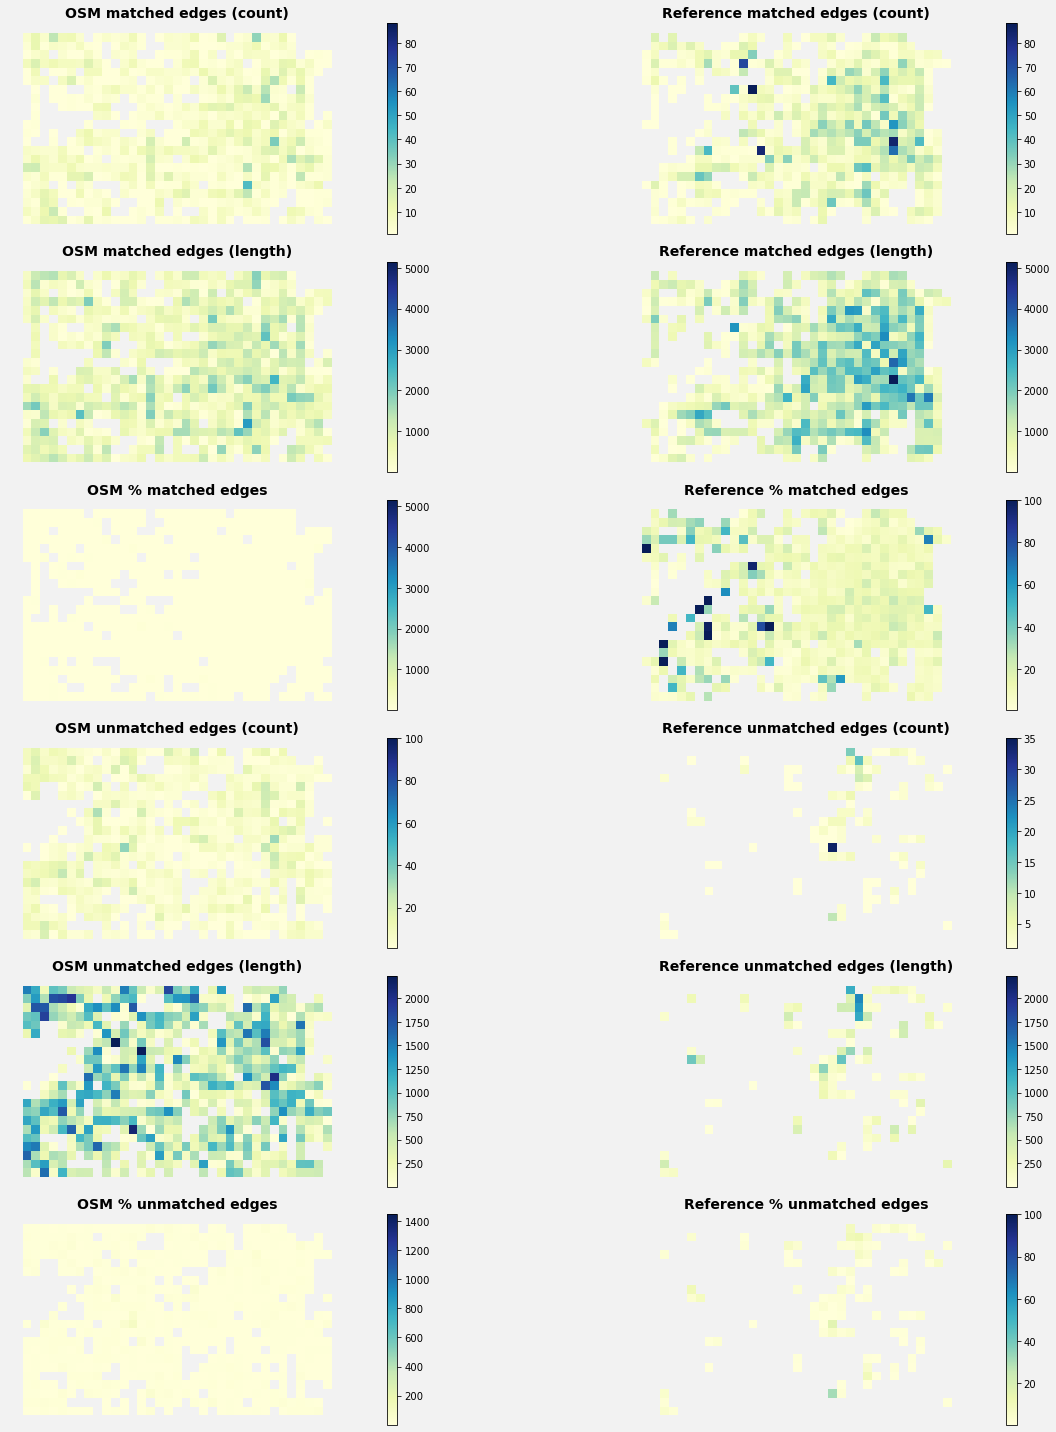

In [48]:
fig_feature_matching, axes = plt.subplots(nrows=6,ncols=2, figsize=(20,20))

axes = axes.flatten()

fig_feature_matching.set_facecolor('#f2f2f2')

plot_cols = [
    'count_osm_matched', 'count_ref_matched',
    'length_osm_matched', 'length_ref_matched',
    'pct_matched_osm', 'pct_matched_ref',
    'count_osm_unmatched', 'count_ref_unmatched',
    'length_osm_unmatched', 'length_ref_unmatched',
    'pct_unmatched_osm', 'pct_unmatched_ref'
    ]

titles = [
    'OSM matched edges (count)', 'Reference matched edges (count)',
    'OSM matched edges (length)', 'Reference matched edges (length)',
    'OSM % matched edges', 'Reference % matched edges',
    'OSM unmatched edges (count)', 'Reference unmatched edges (count)',
    'OSM unmatched edges (length)', 'Reference unmatched edges (length)',
    'OSM % unmatched edges', 'Reference % unmatched edges',
    ]

cmap = 'YlGnBu'

for i, c in enumerate(plot_cols):
    ax = axes[i]
    ax.set_axis_off()

    if i in [0,2]:
        max_value = max(grid_fm[c].max(),grid_fm[plot_cols[i+1]].max())
        min_value = min(grid_fm[c].min(),grid_fm[plot_cols[i+1]].min())

    else:
        max_value = max(grid_fm[c].max(),grid_fm[plot_cols[i-1]].max())
        min_value = min(grid_fm[c].min(),grid_fm[plot_cols[i-1]].min())
    
    grid_fm.plot(column=c, ax=ax, legend=True,vmin=min_value, vmax=max_value, cmap=cmap)

    ax.set_title(titles[i], {'fontsize': 14,'fontweight': 'bold'})

plt.tight_layout()


____________________________

### 5. Export plots

In [17]:
fig_completeness.savefig(f'../results/plots/ext_summary_of_completeness_{study_area}.png')
fig_structure.savefig(f'../results/plots/ext_summary_of_structure_{study_area}.png')
fig_components.savefig(f'../results/plots/ext_summary_of_components_{study_area}.png')
fig_feature_matching.savefig(f'../results/plots/ext_summary_of_fm_{study_area}.png')

__________